# 1. Load dataset

In [1]:
import sys
import pandas as pd
sys.path.append('../EDA/analysis-tools')
from analysis_tools.common.utils import *
from analysis_tools import utils, random, eda

train = pd.read_csv('../../data/train_fe_with_lag.csv')
test = pd.read_csv('../../data/test.csv')

# 2. Construct dataset for modeling

In [2]:
def print_shape(*args):
    print("* Shape of dataset")
    for arg in args:
        print(f"  - {arg.shape}")

def drop_missing_data(inp_prev, out_prev):
    inp_after, out_after = [], []
    for inp, out in zip(inp_prev, out_prev):
        if (np.isnan(inp).sum() == 0) and (np.isnan(out).sum() == 0):
            inp_after.append(inp)
            out_after.append(out)
    return np.array(inp_after), np.array(out_after)

def sliding_window(df, in_seq_len, out_seq_len, stride):
    inp_df = df.iloc[:-out_seq_len]
    out_df = df.iloc[in_seq_len:]

    inps = []
    outs = []
    for i in range(0, len(df) - in_seq_len - out_seq_len + 1, stride):
        inp = inp_df.iloc[i:i + in_seq_len]
        out = out_df.iloc[i:i + out_seq_len]
        if (inp.isnull().values.any()) or (out.isnull().values.any()):
            continue
        inps.append(inp.values)
        outs.append(out.values)
    return np.array(inps), np.array(outs)

def windows_from_dataframe(df, in_seq_len, out_seq_len, stride):
    df = df.astype('float32')
    if len(df) == in_seq_len:  # test dataframe
        inp = [df.values]  # expand_dim
        out = None
        inp, _ = drop_missing_data(inp, inp)
    else:
        inp, out = sliding_window(df, in_seq_len, out_seq_len, stride)
        inp, out = drop_missing_data(inp, out)
    return inp, out

def scale(data, scaler):
    if not isinstance(data, np.ndarray):
        data = np.array(data, dtype='float32')
    if len(data.shape) == 3:
        return scaler.transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
    elif len(data.shape) == 2:
        return scaler.transform(data)
    else:
        raise ValueError("len(data.shape) should be 2 or 3")
        
def inverse_scale(data, scaler):
    if len(data.shape) == 3:
        return scaler.inverse_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
    elif len(data.shape) == 2:
        return scaler.inverse_transform(data)
    else:
        raise ValueError("len(data.shape) should be 2 or 3")

In [3]:
def get_idxs_abnormal(data):
    cond1 = (data['Patv'] <= 0) & (data['Wspd'] > 2.5)
    cond2 = (data['Pab1'] > 89) | (data['Pab2'] > 89) | (data['Pab3'] > 89)
    cond3 = (data['Wdir'] < -180) | (data['Wdir'] > 180) | (data['Ndir'] < -720) | (data['Ndir'] > 720)
    cond4 = data['Patv'].isnull()
    cond  = cond1 | cond2 | cond3 | cond4
    return np.where(cond)[0], np.where(cond1)[0], np.where(cond2)[0], np.where(cond3)[0], np.where(cond4)[0]

def mark_abnormal_Patv(data):
    data = copy(data)
    data['Abnormal'] = 0
    data[[f'Abnormal_{i}' for i in [1, 2, 3, 4]]] = 0
    idxs_full, idxs_1, idxs_2, idxs_3, idxs_4 = get_idxs_abnormal(data)
    for num, i in enumerate([idxs_1, idxs_2, idxs_3, idxs_4], start=1):
        data.loc[data.iloc[i].index, f'Abnormal_{num}'] = 1
    data.loc[data.iloc[idxs_full].index, 'Abnormal'] = 1
    
#     # Plot
#     fig, axes = plt.subplots(5, figsize=(40, 8))
#     for ax, col in zip(axes, ['Abnormal'] + [f'Abnormal_{i}' for i in [1, 2, 3, 4]]):
#         sns.boxplot(x='Patv', y=col, data=data, orient='h', ax=ax);
#     for ax in axes[:-1]:
#         ax.set_xticklabels([])
#         ax.set_xlabel(None)        

    # Adjust Patv
    data['Patv'] = data['Patv'].where(data['Abnormal_2'] == 0, 0)
    data['Patv'] = data['Patv'].where(data['Abnormal_3'] == 0, 0)

    data['Ndir'] = np.clip(data['Ndir'], -720, 720)
    data['Wdir'] = np.clip(data['Wdir'], -180, 180)
    for i in [1, 2, 3]:
        data[f'Pab{i}'] = np.clip(data[f'Pab{i}'], 0, 89)
    
    return data

In [4]:
target = 'Patv'
cols  = ['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab', 'Prtv', 'RPM', target]
cols += ['Wdir_extreme', 'Wdir_comb', 'Ndir_cos_abs', 'Ndir_extreme', 'Pab_extreme1', 'Pab_extreme2', 'Prtv_pos', 'Prtv_abs', 'Prtv_comb', 'Wspd_cube', 'Patan_abs']

cols_inp     = cols
cols_out     = [target]
cols_out_raw = [target]

cols         = list((set(cols_inp) | set(cols_out)) - {target}) + [target]
idx_cols_inp = [cols.index(col) for col in cols_inp]
idx_cols_out = [cols.index(col) for col in cols_out]

input_days  = 2
IN_SEQ_LEN  = input_days*144
OUT_SEQ_LEN = 2*144
STRIDE      = 2*144

tids   = train['TurbID'].unique()
n_tids = len(tids)

train_inp, train_out = n_tids*[None], n_tids*[None]
val_inp,   val_out   = n_tids*[None], n_tids*[None]
test_inp,  test_out  = n_tids*[None], n_tids*[None]

days       = sorted(train['Day'].unique())
train_data = train[train['Day'].isin(days[:-input_days-30])]
val_data   = train[train['Day'].isin(days[-input_days-30:-input_days])]
test_data  = train[train['Day'].isin(days[-input_days:])]
test_data_raw_mark = mark_abnormal_Patv(test)

In [5]:
for i, tid in tqdm(list(enumerate(tids))):
    d_train = train_data.loc[train_data['TurbID'] == tid, cols]
    d_val   = val_data.loc[val_data['TurbID'] == tid, cols]
    d_test  = test_data.loc[test_data['TurbID'] == tid, cols]
    
    train_inp[i], train_out[i] = windows_from_dataframe(d_train, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE)
    val_inp[i],   val_out[i]   = windows_from_dataframe(d_val, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE)
    test_inp[i],  _            = windows_from_dataframe(d_test, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE)
    test_out[i] = [test_data_raw_mark.query(f"TurbID == {tid}")[cols_out_raw].values]
    
train_inp = np.concatenate(train_inp)[..., idx_cols_inp]
train_out = np.concatenate(train_out)[..., idx_cols_out]

val_inp = np.concatenate(val_inp)[..., idx_cols_inp]
val_out = np.concatenate(val_out)[..., idx_cols_out]

test_inp = np.concatenate(test_inp)[..., idx_cols_inp]
test_out = np.concatenate(test_out)

print_shape(train_inp, train_out, val_inp, val_out, test_inp, test_out)

100%|██████████| 134/134 [00:05<00:00, 22.37it/s]


* Shape of dataset
  - (10184, 288, 20)
  - (10184, 288, 1)
  - (1876, 288, 20)
  - (1876, 288, 1)
  - (134, 288, 20)
  - (134, 288, 1)


# 3. Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler_inp = MinMaxScaler()
scaler_inp.fit(train_inp.reshape(-1, train_inp.shape[-1]))
train_inp_scale = scale(train_inp, scaler_inp)
val_inp_scale   = scale(val_inp, scaler_inp)
test_inp_scale  = scale(test_inp, scaler_inp)

scaler_out = MinMaxScaler()
scaler_out.fit(train_out.reshape(-1, train_out.shape[-1]))
train_out_scale = scale(train_out, scaler_out)
val_out_scale   = scale(val_out, scaler_out)
test_out_scale  = scale(test_out, scaler_out)

input_shape  = train_inp.shape[1:]
output_shape = train_out.shape[1:]
print_shape(train_inp_scale, train_out_scale,
            val_inp_scale, val_out_scale,
            test_inp_scale, test_out_scale)

* Shape of dataset
  - (10184, 288, 20)
  - (10184, 288, 1)
  - (1876, 288, 20)
  - (1876, 288, 1)
  - (134, 288, 20)
  - (134, 288, 1)


# 4. DataLoader

In [8]:
from analysis_tools import modeling
import torch

BATCH_SIZE  = 32
SHUFFLE     = True
device = torch.device('cuda:0')

train_dl = modeling.generate_dataloader_torch(train_inp_scale, train_out_scale, BATCH_SIZE, SHUFFLE, device=device)
val_dl   = modeling.generate_dataloader_torch(val_inp_scale, val_out_scale, BATCH_SIZE, shuffle=False, device=device)
test_dl  = modeling.generate_dataloader_torch(test_inp_scale, test_out_scale, BATCH_SIZE, shuffle=False, device=device)

# 5. Transformer

In [9]:
from torch import nn

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
    def forward(self, y, yhat):
        return torch.sqrt(self.mse(yhat, y))
    
class CondLoss(nn.Module):
    def __init__(self, loss_fn, cols_out, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = loss_fn
        self.cols_out = cols_out
        if 'Abnormal' in self.cols_out:
            self.idx_abnormal = cols_out.index('Abnormal')
            self.idx_target   = cols_out.index(target)
        
        if self.loss_fn == 'rmse':
            self.loss_fn = RMSELoss()
        elif self.loss_fn == 'mse':
            self.loss_fn = nn.MSELoss()
        elif self.loss_fn == 'mae':
            self.loss_fn = nn.L1Loss()
        elif self.loss_fn == 'huber':
            self.loss_fn = nn.HuberLoss()
        else:
            raise NotImplementedError
        
    def forward(self, y_true, y_pred):
        _, S_, D_ = y_true.shape  # Batch, Sequence, Dim of features
        y_true = torch.reshape(y_true, (-1, D_))
        y_pred = torch.reshape(y_pred, (-1, D_))
        
        if 'Abnormal' in self.cols_out:
            idxs_valid = (y_true[:, self.idx_abnormal] != 1)
            y_true_normal, y_pred_normal = y_true[idxs_valid, self.idx_target], y_pred[idxs_valid, self.idx_target]
            return self.loss_fn(y_true_normal, y_pred_normal)
        else:
            return self.loss_fn(y_true, y_pred)

In [10]:
import sys
sys.path.append('transformer')

from tst import Transformer
from torch import optim
from livelossplot import PlotLosses
    
# Model parameters
d_model = 32  # Lattent dim
q = 8  # Query size
v = 8  # Value size
h = 8  # Number of heads
N = 2  # Number of encoder and decoder to stack
attention_size = None # Attention window size
dropout = 0.1 # Dropout rate
pe = 'original' # Positional encoding
chunk_mode = None

d_input  = input_shape[-1] # From dataset
d_output = output_shape[-1] # From dataset

# Load transformer with Adam optimizer and MSE loss function
model = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_function = CondLoss('rmse', cols_out)

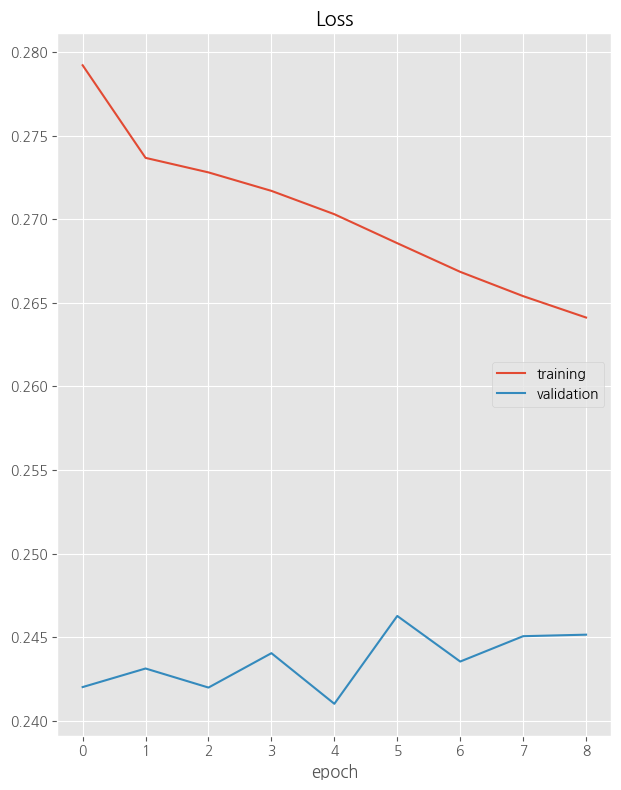

 45%|████▌     | 9/20 [01:29<01:49,  9.94s/it]

Loss
	training         	 (min:    0.264, max:    0.279, cur:    0.264)
	validation       	 (min:    0.241, max:    0.246, cur:    0.245)


 45%|████▌     | 9/20 [01:39<02:01, 11.06s/it]


In [12]:
EPOCHS = 20
val_loss_best = np.inf

liveloss = PlotLosses()
rst = pd.DataFrame(columns=['loss', 'val_loss'], index=pd.Index([], name='Epoch'))

os.makedirs('/root/workspace/modeling/transformer_ckpt', exist_ok=True)
model_save_path = join('/root/workspace/modeling/transformer_ckpt', f'model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth')

max_patience = 5
patience = max_patience
for epoch in tqdm(range(1, EPOCHS+1)):
    losses = []
    for inp, out in train_dl:
        optimizer.zero_grad()
        netout = model(inp.to(device))
        loss = loss_function(out[:, :2*144, :].to(device), netout[:, :2*144, :])
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    with torch.no_grad():
        val_losses = []
        for inp, out in val_dl:
            netout = model(inp.to(device))
            val_loss = loss_function(out[:, :2*144, :].to(device), netout[:, :2*144, :])
            val_losses.append(val_loss.item())
    
    loss, val_loss = np.mean(losses), np.mean(val_losses)
    if val_loss < val_loss_best:
        patience = max_patience
        val_loss_best = val_loss
        torch.save(model.state_dict(), model_save_path)
    else:
        patience -= 1
        if patience == 0:
            break
    
    rst.loc[epoch] = [loss, val_loss]
    liveloss.update(rst.loc[epoch])
    liveloss.send()

# 6. Result

In [16]:
def plot_result(model, scaler_inp, scaler_out, cols_inp, cols_out, datasets, n_cols=5, figsize=(40, 20)):
    def metric(y, p):
        res = y-p
        res = res[~np.isnan(res)]
        return (np.abs(res).mean() + np.sqrt(((res)**2).mean()))/2
    
    for name, ds in datasets.items():
        outs_scale = []
        p_outs_scale = []
        for in_scale, out_scale in ds:
            p_out_scale = model(in_scale[:, :2*144, :].to(device)).detach().cpu().numpy()
            outs_scale.append(out_scale[:, :2*144, :].detach().cpu().numpy())
            p_outs_scale.append(p_out_scale)
            
        outs_scale = np.concatenate(outs_scale)
        p_outs_scale = np.concatenate(p_outs_scale)

        outs = inverse_scale(outs_scale, scaler_out)[..., -1].reshape(-1)
        p_outs = inverse_scale(p_outs_scale, scaler_out)[..., -1].reshape(-1)
        print(f"[{name}] mean(MAE, RMSE): {metric(outs, p_outs):.2f}")
        
        for inp, out in ds:
            inp = inp[:n_cols]
            out = out[:n_cols][:, :2*144, :].detach().cpu().numpy()
            p_out = model(inp.to(device))[:, :2*144, :].detach().cpu().numpy()
            inp = inp[:, :2*144, :].detach().cpu().numpy()
            break
            
        inps   = [pd.DataFrame(inverse_scale(d, scaler_inp), columns=cols_inp, dtype='float32') for d in inp]
        outs   = [pd.DataFrame(inverse_scale(d, scaler_out), columns=cols_out) for d in out]
        p_outs = [pd.DataFrame(inverse_scale(d, scaler_out), columns=cols_out) for d in p_out]
        
        n_rows = out.shape[-1]
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        if axes.ndim == 1:
            axes = [axes]
        for ax_col, col in zip(axes, cols_out):
            for idx_row, (ax, out, p_out) in enumerate(zip(ax_col, outs, p_outs)):
                ax.plot(out[col], label='true')
                ax.plot(p_out[col], label=f'pred ({np.mean(abs(p_out[col]-out[col])):.3f})')
                ax.fill_between(range(len(out[col])), out[col], p_out[col], alpha=0.1, color='b')
                ax.set_xticklabels([])
                ax.legend()
                if idx_row == 0:
                    ax.set_ylabel(col)
        fig.tight_layout()
        plt.show()

### - Training, Validation set

[train] mean(MAE, RMSE): 367.58


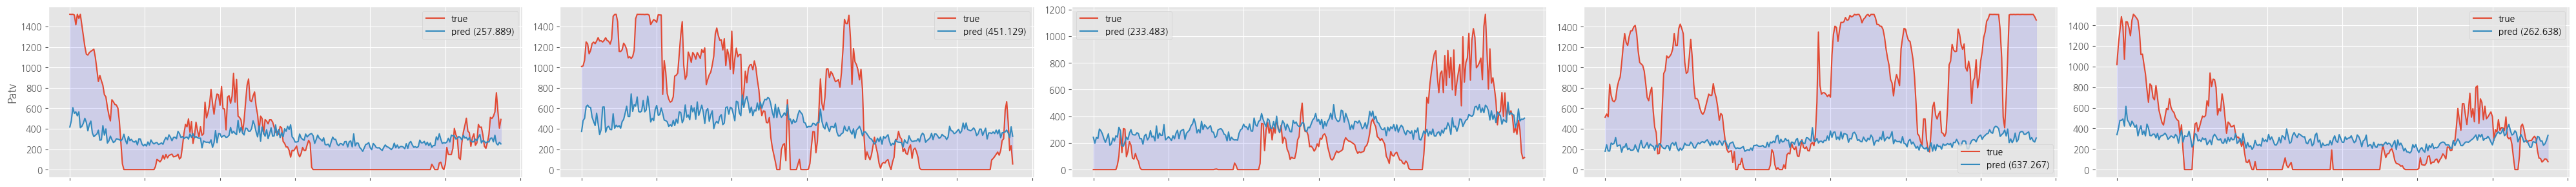

[val] mean(MAE, RMSE): 342.92


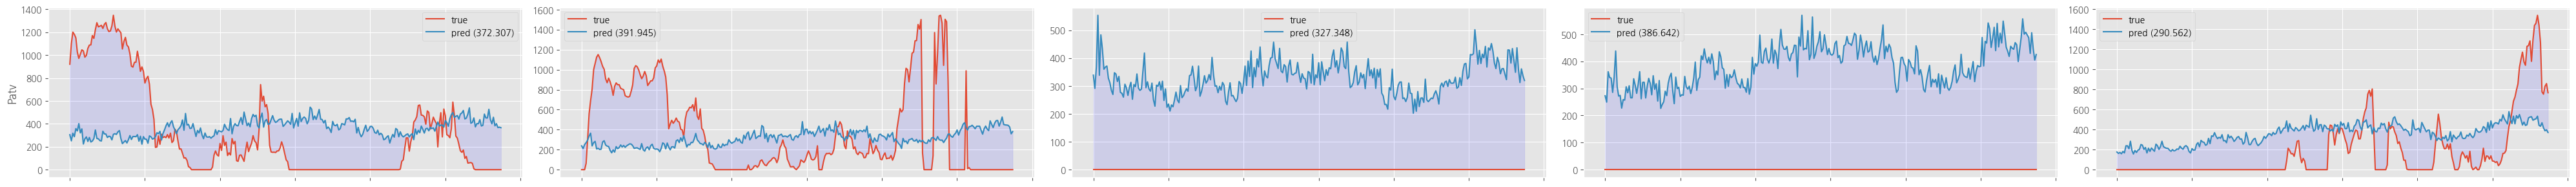

In [17]:
plot_result(model, scaler_inp, scaler_out, cols_inp, cols_out, {'train': train_dl, 'val': val_dl}, figsize=(40, 3))

### - Test set

[test] mean(MAE, RMSE): 476.91


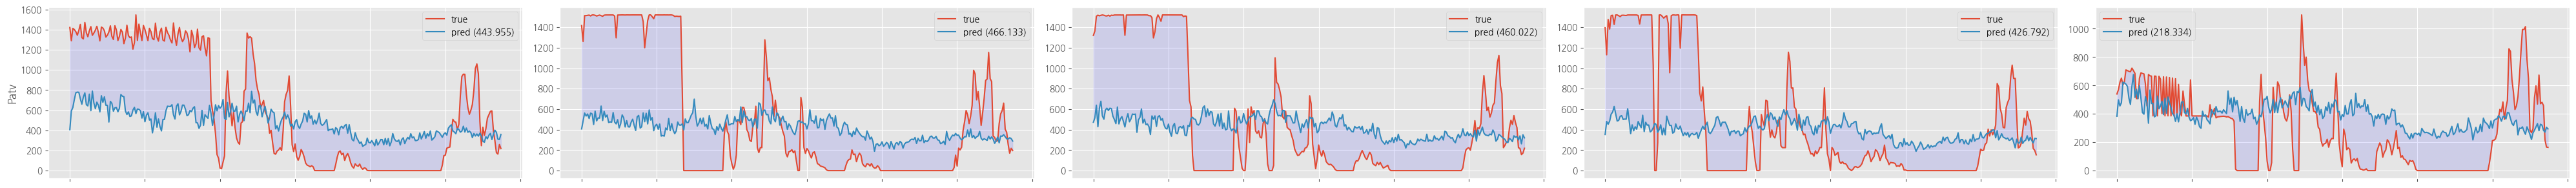

In [18]:
plot_result(model, scaler_inp, scaler_out, cols_inp, cols_out, {'test': test_dl}, figsize=(40, 3))